In [33]:
# We define the functions here


import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:/SenkDosya/UTAT/Github/FINCH-Science") # Add path for the Unmixing_Methods folder, the string is different for you probably
from Unmixing_Methods.Conventional_Unmixing_Methods.SOO_RMSE import SOO_RMSE
from Unmixing_Methods.Unconventional_Unmixing_Methods.KLDiv import kl_divergence_unmixing
from scipy.stats import linregress


In [34]:
# Data generation options go here

SNR_Options = [100,140,180]

VZA_SNR_Options = []

VZA_Options = []

Best_EM_Choice = [1438, 1054, 1377] #refer indices to the simpler_data_rwc
Worst_EM_Choice = [1438, 356, 1395] #same as EM_Choice, but the worst choices now

EM_Choice = [1438, 1054, 1395]

Spectra_Range_Index = [116,136  +1] #selected range: 1500-1650, refer indices to a dataset that has rwc columns and no original indices column
                                # WARNING!!!! Write the last index +1 since python slicing STOPS at that last index and DOES NOT include it (THIS IS RELATED TO PYTHON, WILL NOT CHANGE)
                                # for 900-1700: 57,137
                                # for 1500-1650: 117, 132
                                # for 1150-1340: 80, 99
                                # for 950-1120: 60, 76
                                # for 1490-1700: 116, 136

simpler_data_rwc_handle = r"C:\SenkDosya\UTAT\Data\General_Data\simpler_data_rwc.csv" # PATH HANDLE for simpler_data_snr goes here keep .csv
simpler_data_snr_handle = r"C:\SenkDosya\UTAT\Data\General_Data\Noised_Data\simpler_data_SNR_" # PATH HANDLE for simpler_data_snr goes here omit the SNR VAL and .csv
conference_data_vza_handle = r"C:\SenkDosya\UTAT\Data\Conference_Data\csrs2025_" # PATH HANDLE for csrs2025_VZA goes here omit the VZA and .csv
conference_data_vza_snr_handle = r"C:\SenkDosya\UTAT\Data\Conference_Data\Noised_155_csrs2025\155_csrs2025_SNR_" # PATH HANDLE for 155 VZa varying SNR goes here omit the VZA and .csv

c_scaling = 100000 # Scaling constant for derivative unmixing

In [35]:
# Actual data manipulation

for i in SNR_Options:
    
    globals()[f'lib_SNR_{i}'] = pd.read_csv(rf"{simpler_data_snr_handle+str(i)}.csv")

    # Extract abundances for the entire dataset
    if  SNR_Options[0]== i:
        true_abundances_matrix_all = (globals()[f'lib_SNR_{i}'].iloc[:, 1:4]).to_numpy() #create the abundances matrix here
        print("Abundance MATRIX for ALL, COMPLETE.")
    
    globals()[f'values_lib_SNR_{i}'] = (globals()[f'lib_SNR_{i}'].iloc[:, Spectra_Range_Index[0]-2:Spectra_Range_Index[1]-2]) # -2 since SNR does not have rwc, THIS MAY CHANGE IN THE FUTURE
    globals()[f'values_lib_deriv_SNR_{i}'] = (dataframe_derivative(globals()[f'values_lib_SNR_{i}'])* c_scaling).to_numpy()
    globals()[f'values_lib_SNR_{i}'] = (globals()[f'values_lib_SNR_{i}']).to_numpy()


print("SNR data generation, COMPLETE.")

for i in VZA_Options:
    
    globals()[f'lib_VZA_{i}'] = pd.read_csv(rf"{conference_data_vza_handle+str(i)}.csv")

    # Extract abundances for the conference dataset
    if VZA_Options[0] == i:
        true_abundances_matrix_conf = (globals()[f'lib_VZA_{i}'].iloc[:,2:5]).to_numpy()
        print("Abundance MATRIX for CONFERENCE, COMPLETE.")

    globals()[f'values_lib_VZA_{i}'] = (globals()[f'lib_VZA_{i}'].iloc[:, Spectra_Range_Index[0]+1:Spectra_Range_Index[1]+1]) #+1 since these datasets have a index referral column, this WILL NOT CHANGE IN THE FUTURE, MOST LIKELY
    globals()[f'values_lib_deriv_VZA_{i}'] = (dataframe_derivative(globals()[f'values_lib_VZA_{i}'])* c_scaling).to_numpy()
    globals()[f'values_lib_VZA_{i}'] = (globals()[f'values_lib_VZA_{i}']).to_numpy()

print("VZA data generation, COMPLETE.")

for i in VZA_SNR_Options:
    
    globals()[f'lib_155VZA_SNR_{i}'] = pd.read_csv(rf"{conference_data_vza_snr_handle+str(i)}.csv")

    # Extract abundances for the conference dataset
    if VZA_Options[0] == i:
        true_abundances_matrix_conf = (globals()[f'lib_155VZA_SNR_{i}'].iloc[:,2:5]).to_numpy()
        print("Abundance MATRIX for CONFERENCE, COMPLETE.")

    globals()[f'values_lib_155VZA_SNR_{i}'] = (globals()[f'lib_155VZA_SNR_{i}'].iloc[:, Spectra_Range_Index[0]+1:Spectra_Range_Index[1]+1]) #+1 since these datasets have a index referral column, this WILL NOT CHANGE IN THE FUTURE, MOST LIKELY
    globals()[f'values_lib_deriv_155VZA_SNR_{i}'] = (dataframe_derivative(globals()[f'values_lib_155VZA_SNR_{i}'])* c_scaling).to_numpy()
    globals()[f'values_lib_155VZA_SNR_{i}'] = (globals()[f'values_lib_155VZA_SNR_{i}']).to_numpy()

print("155 VZA varying SNR data generation, COMPLETE.")

# here, we have to pull the EM dataset that we'll use to unmix with, these shall not be tempered, we are cutting out the unuseful stuff
values_lib_em = ((pd.read_csv(simpler_data_rwc_handle)).iloc[EM_Choice, Spectra_Range_Index[0]:Spectra_Range_Index[1]]).to_numpy()
values_lib_deriv_em = (dataframe_derivative((pd.read_csv(simpler_data_rwc_handle)).iloc[EM_Choice, Spectra_Range_Index[0]:Spectra_Range_Index[1]])* c_scaling).to_numpy()
values_lib_em_worst = ((pd.read_csv(simpler_data_rwc_handle)).iloc[Worst_EM_Choice, Spectra_Range_Index[0]:Spectra_Range_Index[1]]).to_numpy()
values_lib_deriv_em_worst =(dataframe_derivative((pd.read_csv(simpler_data_rwc_handle)).iloc[Worst_EM_Choice, Spectra_Range_Index[0]:Spectra_Range_Index[1]])* c_scaling).to_numpy()
print("EM data generation, COMPLETE.")
print("WARNING: All the outputs are in arrays.")

Abundance MATRIX for ALL, COMPLETE.
SNR data generation, COMPLETE.
VZA data generation, COMPLETE.
155 VZA varying SNR data generation, COMPLETE.
EM data generation, COMPLETE.


In [36]:
# Unmixing calculations WARNING!! THIS CELL TAKES MORE THAN 10 MINS AT EGE'S COMPUTER (CPU: 8700K) YOU CAN RUN THIS CELL AND LEAVE THE COMPUTER, THIS TAKES LOOOOOOOOOOOOOOOOOOOOOOOOOOONG



# Now calculations on SNR:

for i in SNR_Options:

    globals()[f'abundances_RMSE_SNR_{i}'],_,_ = SOO_RMSE(pd.DataFrame(globals()[f'values_lib_SNR_{i}']), pd.DataFrame(values_lib_em), plot_results=False)
    globals()[f'abundances_RMSE_SNR_{i}'] = (globals()[f'abundances_RMSE_SNR_{i}']).to_numpy()

    globals()[f'abundances_Derivative_SNR_{i}'],_,_ = SOO_RMSE(pd.DataFrame(globals()[f'values_lib_deriv_SNR_{i}']), pd.DataFrame(values_lib_deriv_em), plot_results=False)
    globals()[f'abundances_Derivative_SNR_{i}'] = (globals()[f'abundances_Derivative_SNR_{i}']).to_numpy()

    globals()[f'abundances_KLDiv_SNR_{i}'] = np.zeros(shape=((globals()[f'values_lib_SNR_{i}']).shape[0], 3))

    for j in range(globals()[f'values_lib_SNR_{i}'].shape[0]):
        (globals()[f'abundances_KLDiv_SNR_{i}'])[j] = kl_divergence_unmixing(globals()[f'values_lib_SNR_{i}'][j,:], values_lib_em,False)

    if i == SNR_Options[-1]:
        print("Abundances calculated for all SNRs using Spectral RMSE, Derivative RMSE, KL-Div.")






Abundances calculated for all SNRs using Spectral RMSE, Derivative RMSE, KL-Div.


In [37]:
# Define plotting functions

def plot_abundance_comparison(true_ab_df: pd.DataFrame, optimized_ab_df: pd.DataFrame, title: str = "Abundance Comparison", goalline: bool = True, best_fit: bool = False):
    """
    Creates a scatter plot comparing optimized abundance (y-axis) with true abundances (x-axis).
    """

    types = ['gv_fraction', 'npv_fraction', 'soil_fraction']
    colors = ['green', 'blue', 'brown']
    darkened_colors = ['darkgreen', 'darkblue', 'saddlebrown']
    # Create a scatter plot for each column (abundance type)

    fig, ax = plt.subplots(figsize=(8, 6))

    for column in optimized_ab_df.columns:
        ax.scatter(true_ab_df[column], optimized_ab_df[column], label=types[column], color=colors[column])

    if goalline:
        # Add a y=x line for the goal
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Goal Line (y=x)')

    if best_fit:
        for column in optimized_ab_df.columns:
            # Calculate the best fit line
            slope, intercept, r_value, p_value, std_err = linregress(true_ab_df[column], optimized_ab_df[column])
            r_value = r_value **2
            print(f"Best fit line for {types[column]}: slope = {slope}, intercept = {intercept}, r^2 = {r_value**2}")
            ax.plot(true_ab_df[column], slope * (true_ab_df[column]) + intercept, color=darkened_colors[column], linestyle='--', label=f'Best Fit {types[column]}')
    
    ax.set_ylabel('Optimized Abundance')
    ax.set_xlabel('True Abundance')
    ax.set_title(title)

    plt.show()

def plot3_abundance_comparison(ax, true_ab_df: pd.DataFrame, optimized_ab_df: pd.DataFrame,title: str = "Abundance Comparison", goalline: bool = True, best_fit: bool = False):
    """
    Creates a scatter plot comparing optimized abundance (y-axis) with true abundances (x-axis).
    
    Note: if using multiplot, ax should be passed as an argument, otherwise it will create a new figure and axis.
    And fig, ax = plt.subplots(1, 3, figsize=(15, 5)) must be used to create the subplots.
    """

    types = ['gv_fraction', 'npv_fraction', 'soil_fraction']
    colors = ['green', 'blue', 'brown']
    darkened_colors = ['darkgreen', 'darkblue', 'saddlebrown']
    
    for column in optimized_ab_df.columns:
        ax.scatter(true_ab_df[column], optimized_ab_df[column], label=types[column], color=colors[column])

    if goalline:
        # Add a y=x line for the goal
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Goal Line (y=x)')

    if best_fit:
        for column in optimized_ab_df.columns:
            
            # Calculate the best fit line
            slope, intercept, r_value, p_value, std_err = linregress(true_ab_df[column], optimized_ab_df[column])
            r_value = r_value **2
            print(f"Best fit line for {types[column]}: slope = {slope}, intercept = {intercept}, r^2 = {r_value**2}")
            ax.plot(true_ab_df[column], slope * (true_ab_df[column]) + intercept, color=darkened_colors[column], linestyle='--', label=f'Best Fit {types[column]}')
    
    ax.set_ylabel('Optimized Abundance')
    ax.set_xlabel('True Abundance')
    ax.set_title(title)

def plot_single_abundance_comparison(abundance_type: int, true_ab_df: pd.DataFrame, optimized_ab_df: pd.DataFrame, title: str = "Abundance Comparison", goalline: bool = True, best_fit: bool = True):
    """
    Creates a scatter plot comparing optimized abundance (y-axis) with true abundances (x-axis).
    """

    types = ['gv_fraction', 'npv_fraction', 'soil_fraction']
    colors = ['green', 'blue', 'brown']
    
    # Create a scatter plot for each column (abundance type)
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(true_ab_df[abundance_type], optimized_ab_df[abundance_type], label=types[abundance_type], color=colors[abundance_type])

    if goalline:
        # Add a y=x line for the goal
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Goal Line (y=x)')

    if best_fit:
        # Calculate the best fit line
        slope, intercept, r_value, p_value, std_err = linregress(true_ab_df[abundance_type], optimized_ab_df[abundance_type])
        r_value = r_value **2
        print(f"Best fit line for {types[abundance_type]}: slope = {slope}, intercept = {intercept}, r^2 = {r_value**2}") 
        ax.plot(true_ab_df[abundance_type], slope * (true_ab_df[abundance_type]) + intercept, color='magenta', linestyle='--', label=f'Best Fit {types[abundance_type]}')

        return slope, intercept, r_value, p_value, std_err

    
    ax.set_xlabel('Optimized Abundance')
    ax.set_ylabel('True Abundance')
    ax.set_title(title)

    plt.show()

def plot3_single_abundance_comparison(ax, abundance_type: int, true_ab_df: pd.DataFrame, optimized_ab_df: pd.DataFrame, title: str = "Abundance Comparison", goalline: bool = True, best_fit: bool = True):
    """
    Creates a scatter plot comparing optimized abundance (y-axis) with true abundances (x-axis).
    """
    types = ['gv_fraction', 'npv_fraction', 'soil_fraction']
    colors = ['green', 'blue', 'brown']
    
    ax.scatter(true_ab_df[abundance_type], optimized_ab_df[abundance_type], label=types[abundance_type], color=colors[abundance_type])

    if goalline:
        # Add a y=x line for the goal
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Goal Line (y=x)')

    if best_fit:
        # Calculate the best fit line
        slope, intercept, r_value, p_value, std_err = linregress(true_ab_df[abundance_type], optimized_ab_df[abundance_type])
        r_value = r_value **2

        ax.plot(true_ab_df[abundance_type], slope * (true_ab_df[abundance_type]) + intercept, color='magenta', linestyle='--', label=f'Best Fit {types[abundance_type]}')

        return r_value, p_value, std_err, slope, intercept, 
    
    ax.set_ylabel('Optimized Abundance')
    ax.set_xlabel('True Abundance')
    ax.set_title(title)
    

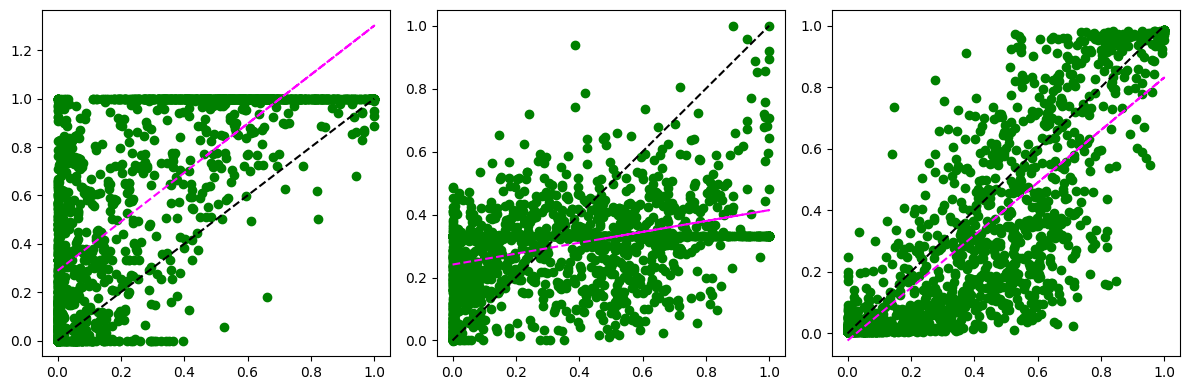

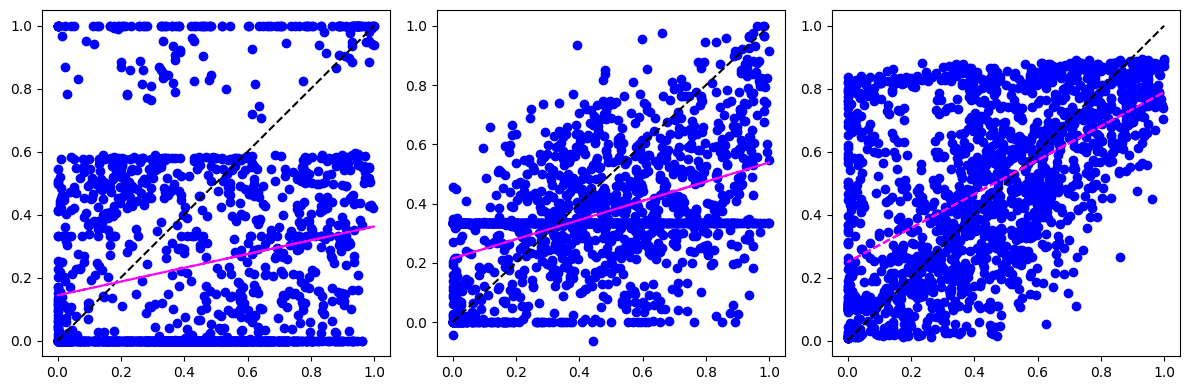

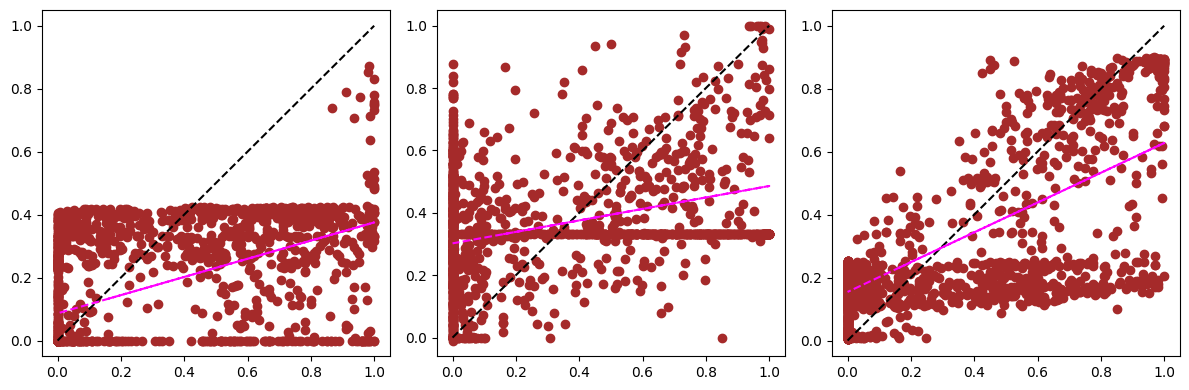

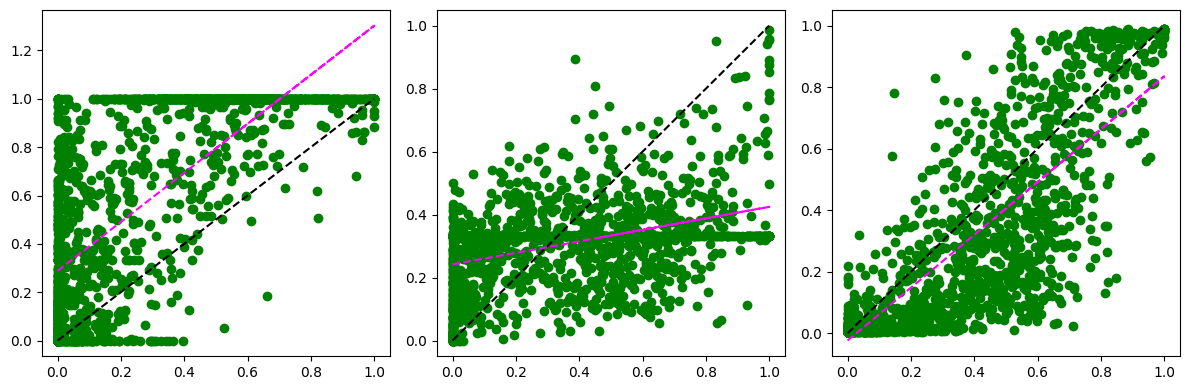

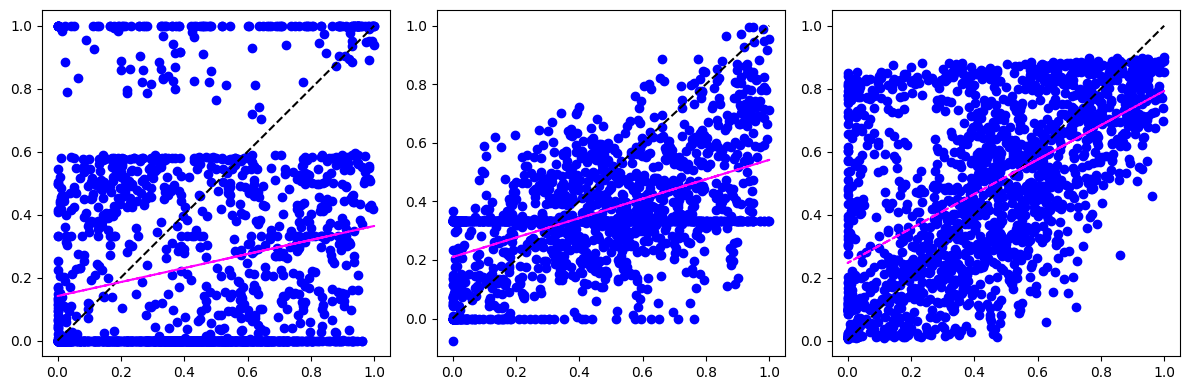

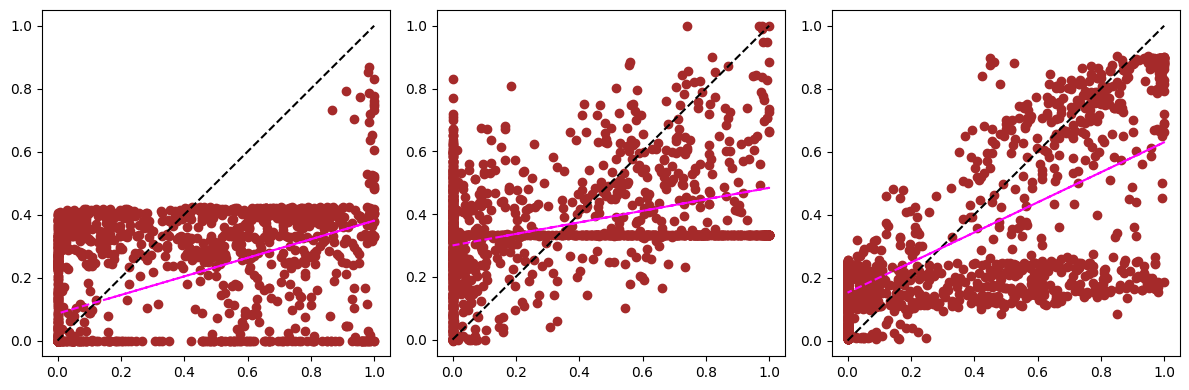

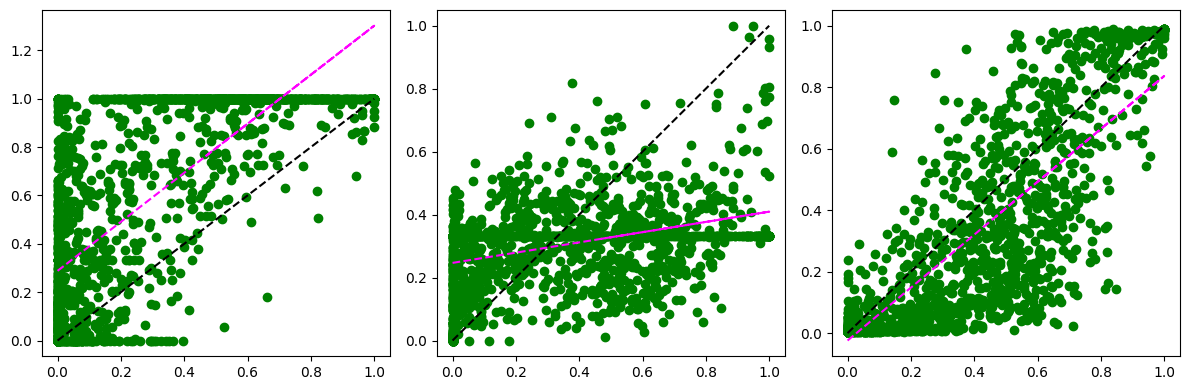

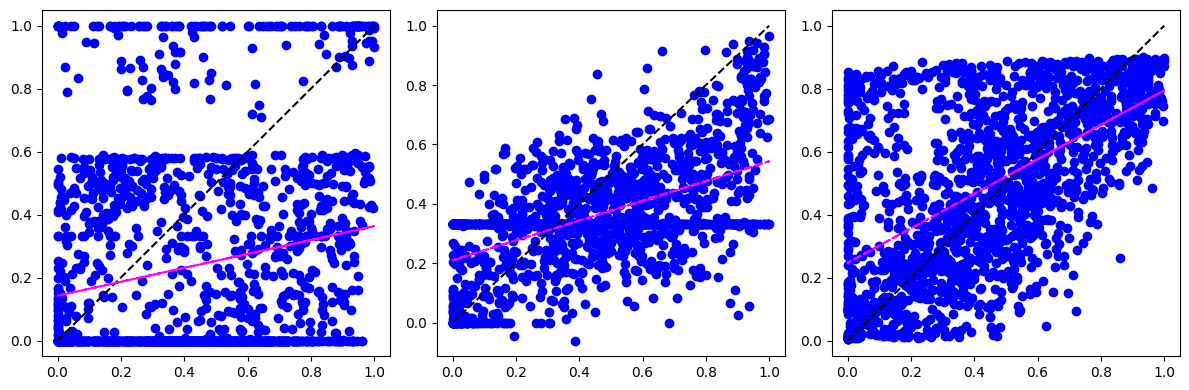

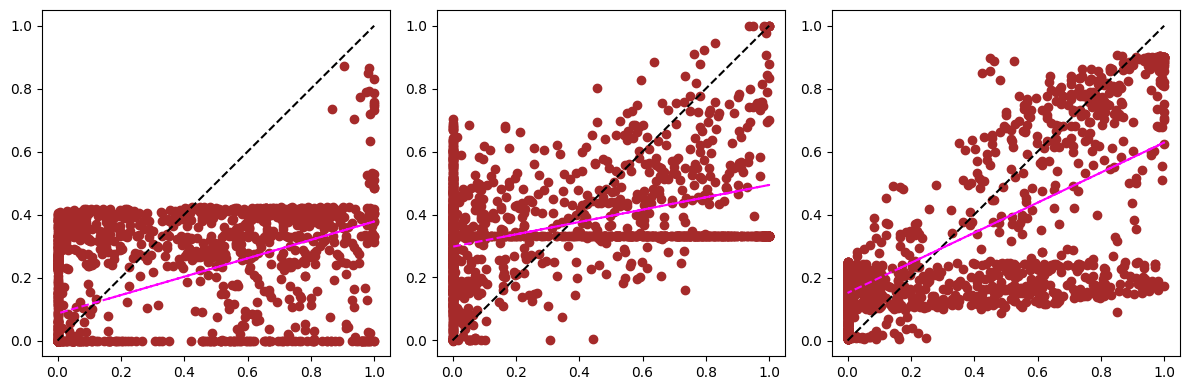

In [38]:
# Plots and statistical outputs for SNR

Results = pd.DataFrame(columns=['SNR', 'R^2', 'P-value', 'Standard Error', 'Slope', 'Intercept'])
Results.astype('object')

for i in range(len(SNR_Options)):
    Results.loc[SNR_Options[i], 'SNR'] = SNR_Options[i]
    Results.loc[SNR_Options[i], 'R^2'] = None
    Results.loc[SNR_Options[i], 'P-value'] = None
    Results.loc[SNR_Options[i], 'Standard Error'] = None
    Results.loc[SNR_Options[i], 'Slope'] = None
    Results.loc[SNR_Options[i], 'Intercept'] = None

Results.to_csv(r"C:\SenkDosya\UTAT\Github\FINCH-Science\Pipelines\CSRS2025\Unmixing_SNR.csv", index=False)

for i in SNR_Options:

    globals()[f'Best_Fit_R2_SNR_{i}'] =  [[None, None, None], [None, None, None], [None, None, None]]  # Initialize the list of lists for R^2
    globals()[f'Best_Fit_P_SNR_{i}'] =  [[None, None, None], [None, None, None], [None, None, None]]  # Initialize the list of lists for P-value
    globals()[f'Best_Fit_Std_SNR_{i}'] =  [[None, None, None], [None, None, None], [None, None, None]]  # Initialize the list of lists for Standard Error
    globals()[f'Best_Fit_Slope_SNR_{i}'] =  [[None, None, None], [None, None, None], [None, None, None]]  # Initialize the list of lists for Slope
    globals()[f'Best_Fit_Intercept_SNR_{i}'] =  [[None, None, None], [None, None, None], [None, None, None]]  # Initialize the list of lists for Intercept


    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    globals()[f'Best_Fit_R2_SNR_{i}'][0][0], globals()[f'Best_Fit_P_SNR_{i}'][0][0], globals()[f'Best_Fit_Std_SNR_{i}'][0][0], globals()[f'Best_Fit_Slope_SNR_{i}'][0][0], globals()[f'Best_Fit_Intercept_SNR_{i}'][0][0] = plot3_single_abundance_comparison(ax[0], 0, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_RMSE_SNR_{i}']), title=f"RMSE Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][1][0], globals()[f'Best_Fit_P_SNR_{i}'][1][0], globals()[f'Best_Fit_Std_SNR_{i}'][1][0], globals()[f'Best_Fit_Slope_SNR_{i}'][1][0], globals()[f'Best_Fit_Intercept_SNR_{i}'][1][0] = plot3_single_abundance_comparison(ax[1], 0, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_Derivative_SNR_{i}']), title=f"Derivative Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][2][0], globals()[f'Best_Fit_P_SNR_{i}'][2][0], globals()[f'Best_Fit_Std_SNR_{i}'][2][0], globals()[f'Best_Fit_Slope_SNR_{i}'][2][0], globals()[f'Best_Fit_Intercept_SNR_{i}'][2][0] = plot3_single_abundance_comparison(ax[2], 0, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_KLDiv_SNR_{i}']), title=f"KL Divergence Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    globals()[f'Best_Fit_R2_SNR_{i}'][0][1], globals()[f'Best_Fit_P_SNR_{i}'][0][1], globals()[f'Best_Fit_Std_SNR_{i}'][0][1], globals()[f'Best_Fit_Slope_SNR_{i}'][0][1], globals()[f'Best_Fit_Intercept_SNR_{i}'][0][1] = plot3_single_abundance_comparison(ax[0], 1, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_RMSE_SNR_{i}']), title=f"RMSE Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][1][1], globals()[f'Best_Fit_P_SNR_{i}'][1][1], globals()[f'Best_Fit_Std_SNR_{i}'][1][1], globals()[f'Best_Fit_Slope_SNR_{i}'][1][1], globals()[f'Best_Fit_Intercept_SNR_{i}'][1][1] = plot3_single_abundance_comparison(ax[1], 1, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_Derivative_SNR_{i}']), title=f"Derivative Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][2][1], globals()[f'Best_Fit_P_SNR_{i}'][2][1], globals()[f'Best_Fit_Std_SNR_{i}'][2][1], globals()[f'Best_Fit_Slope_SNR_{i}'][2][1], globals()[f'Best_Fit_Intercept_SNR_{i}'][2][1] = plot3_single_abundance_comparison(ax[2], 1, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_KLDiv_SNR_{i}']), title=f"KL Divergence Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    globals()[f'Best_Fit_R2_SNR_{i}'][0][2], globals()[f'Best_Fit_P_SNR_{i}'][0][2], globals()[f'Best_Fit_Std_SNR_{i}'][0][2], globals()[f'Best_Fit_Slope_SNR_{i}'][0][2], globals()[f'Best_Fit_Intercept_SNR_{i}'][0][2] = plot3_single_abundance_comparison(ax[0], 2, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_RMSE_SNR_{i}']), title=f"RMSE Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][1][2], globals()[f'Best_Fit_P_SNR_{i}'][1][2], globals()[f'Best_Fit_Std_SNR_{i}'][1][2], globals()[f'Best_Fit_Slope_SNR_{i}'][1][2], globals()[f'Best_Fit_Intercept_SNR_{i}'][1][2] = plot3_single_abundance_comparison(ax[1], 2, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_Derivative_SNR_{i}']), title=f"Derivative Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    globals()[f'Best_Fit_R2_SNR_{i}'][2][2], globals()[f'Best_Fit_P_SNR_{i}'][2][2], globals()[f'Best_Fit_Std_SNR_{i}'][2][2], globals()[f'Best_Fit_Slope_SNR_{i}'][2][2], globals()[f'Best_Fit_Intercept_SNR_{i}'][2][2] = plot3_single_abundance_comparison(ax[2], 2, pd.DataFrame(true_abundances_matrix_all), pd.DataFrame(globals()[f'abundances_KLDiv_SNR_{i}']), title=f"KL Divergence Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plt.tight_layout()
    plt.show()

    # Now, we save the results to the Results dataframe

    Results.loc[i, 'R^2'] = globals()[f'Best_Fit_R2_SNR_{i}']
    Results.loc[i, 'P-value'] = globals()[f'Best_Fit_P_SNR_{i}']
    Results.loc[i, 'Standard Error'] = globals()[f'Best_Fit_Std_SNR_{i}']
    Results.loc[i, 'Slope'] = globals()[f'Best_Fit_Slope_SNR_{i}']
    Results.loc[i, 'Intercept'] = globals()[f'Best_Fit_Intercept_SNR_{i}']

"""
In this final saved CSV,

within a list of a column, the first list of that list would represent a different method

[[Reg-RMSE],[Deriv-RMSE],[KL]]

and within each of these lists, there are three values, one for each abundance type's best fit (GV, NPV, Soil).
"""

Results.to_csv(r"C:\SenkDosya\UTAT\Github\FINCH-Science\Scientific_Requirements\SNR_In_Unmixing\Unmixing_SNR_3rd_Window.csv", index=False) 